In [6]:
import torch
from monai.networks.nets import DynUNet
import torchvision
from torchview import draw_graph

In [32]:
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [7]:

def get_kernels_strides(patch_size, spacing):
    sizes, spacings = patch_size, spacing
    input_size = sizes
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [
            2 if ratio <= 2 and size >= 8 else 1
            for (ratio, size) in zip(spacing_ratio, sizes)
        ]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {input_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides

In [10]:
#Create the model
spatial_dims = 3
max_epochs = 250
in_channels = 1
out_channels=2 #including background
lr = 1e-3#1e-4
weight_decay = 1e-5
T_0 = 40  # Cosine scheduler
image_size = (96,96,96)
task_id = "06"
deep_supr_num = 1  # when is 3 shape of outputs/labels dont match
patch_size = image_size
spacing = [1, 1, 1]
kernels, strides = get_kernels_strides(patch_size, spacing)
model = DynUNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernels,
    strides=strides,
    upsample_kernel_size=strides[1:],
    norm_name="instance",
    deep_supervision=False,  # when is 3 shape of outputs/labels dont match
    deep_supr_num=deep_supr_num,
)

In [26]:
from torch.autograd import Variable
x = Variable(torch.randn(1,1,96,96,96))
y=model(x)

In [33]:
model_graph = draw_graph(model, input_size=(1,1,96,96,96), expand_nested=True)


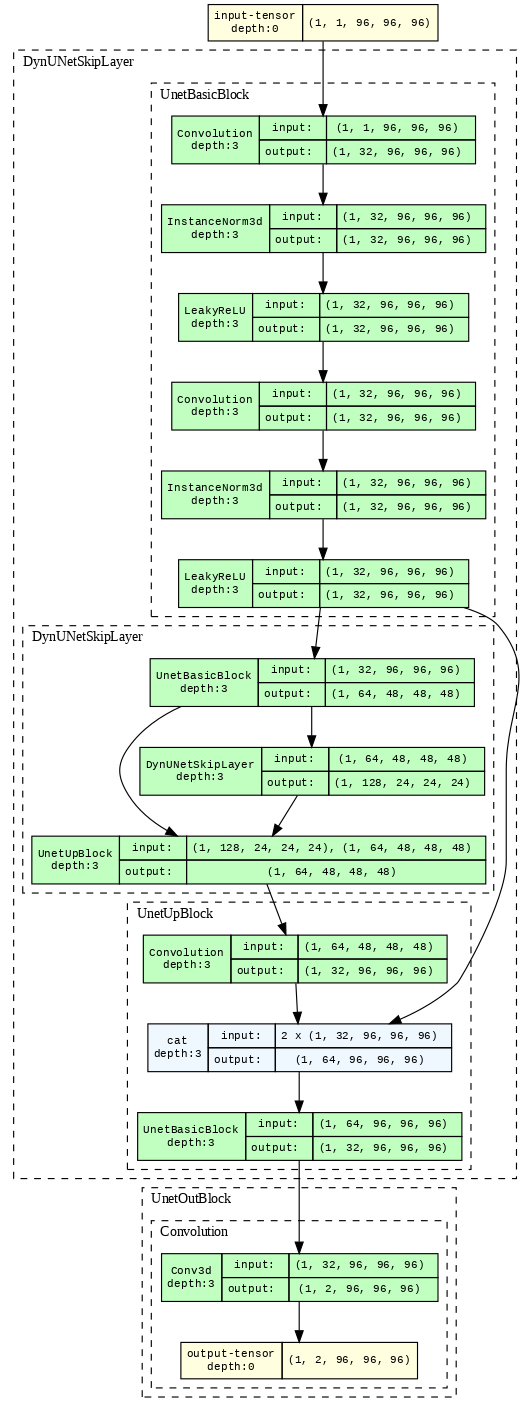

In [34]:
model_graph.visual_graph